In [ ]:
#@title
# Copyright 2020 Google LLC.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

# https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

Author- [@yashkhasbage25](https://github.com/yashkhasbage25 "Yash Khasbage")

# Semantic Segmentation 
Semantic Segmentation is a computer vision task that divides an image into segments, identifying what parts of image belong to what object. 

In this tutorial, we will train a Convolutional neural network to segment images. 

Briefly, we will discuss
1. downloading an image segmentation dataset from kaggle
2. processing the dataset according to our need
3. Create a dataloader
4. Creating a Custom loss function
5. Creating TrainTask and EvalTask 
6. Create a Neural Network and train it

(You need to have a kaggle account for downloading the dataset)

Assuming that you already have a kaggle account, we will first begin by creating a kaggle API token. 
If you don't have API token, follow these steps to create a new one:
1. Go to the Account section of kaggle website, after you login. 
2. Click "Expire API Token" and then "Create New API Token". A file "kaggle.json" will be downloaded. 
3. Using "Choose files" button, upload the kaggle.json file. The API token present in this file will help us download the dataset directly from kaggle. 

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()  # upload kaggle.json
! mkdir ~/.kaggle

Saving kaggle.json to kaggle.json


We need to place kaggle.json at ~/.kaggle and also change its file permissions. 

In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              215KB  2021-03-13 10:04:34            315  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27            362  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44            280  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19            133  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Wo

Now with this command, we actually download the dataset. This may take some time, depending on internet speed.  

In [ ]:
! kaggle datasets download -d dansbecker/cityscapes-image-pairs

 92% 185M/202M [00:03<00:00, 36.9MB/s]
100% 202M/202M [00:03<00:00, 53.9MB/s]


The download has to be uncompressed. 

In [ ]:
! unzip -q cityscapes-image-pairs.zip

Intall trax


In [ ]:
! pip install -q -U trax

     |████████████████████████████████| 522kB 7.7MB/s 
     |████████████████████████████████| 235kB 13.7MB/s 
     |████████████████████████████████| 3.4MB 11.7MB/s 
     |████████████████████████████████| 1.2MB 59.5MB/s 
     |████████████████████████████████| 1.9MB 54.5MB/s 
     |████████████████████████████████| 3.8MB 53.0MB/s 
     |████████████████████████████████| 368kB 53.1MB/s 
     |████████████████████████████████| 61kB 10.3MB/s 
     |████████████████████████████████| 3.2MB 56.4MB/s 
     |████████████████████████████████| 890kB 54.4MB/s 


In [ ]:
# several imports from trax

import trax
import numpy as np
import trax.layers as tl
from trax.fastmath import numpy as jnp

In [ ]:
# several imports out of trax

import os
import os.path as osp
from PIL import Image
from itertools import cycle
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
% matplotlib inline

In [ ]:
# let's fix batch size
batch_size = 32

Some details of the dataset in its original form: 
The original images are of the shape 256x512x3. The left half and the right half of images belong to input and label respectively. In a typical segmentation label, the label should be a 2D matrix consisting of the class label of objects, such that each pixel is alloted a class. In the label images given, we are not directly provided with the class labels. However, each class label is represented with a specific color. We need to map colors to class labels, to convert them into usable format. 

We know that there are total 13 classes in the dataset. Hence, we will be given 13 different colors in labels. For processing the label images, according to the procedure mentioned above, we will use K-Means utility of sklearn.

We do the processing in the following manner

In [ ]:
def color_kmean(root):
  """ creates a k-means objects that recognizes all 13 colors of dataset. """
  
  # take 10 first images
  files = os.listdir(root)[:10] 
  colors = list()
  for f in files:
    img = load_image(osp.join(root, f))
    # total width
    w = img.shape[2]
    # get the right half of image, which is the label image
    img = img[:, w:, :]
    # collect all the colors present in label image
    colors.append(img.reshape(-1, 3))

  colors = np.array(colors)
  colors = colors.reshape(-1, 3)

  # finally, fit all the colors into the KMeans
  kmeans = KMeans(13)
  kmeans.fit(colors)

  return kmeans

def load_image(path):
  """ loading an image. """
  
  assert osp.exists(path), path + " not found"
  image = Image.open(path)
  image = np.asarray(image)
  return image

def color2class(segs, km):
  """ 
  given an label image, convert it to class matrix, 
  which is a 2D matrix of class labels (scalars).
  """
  
  h, w, c = segs.shape
  segs = segs.reshape((-1, 3))
  segs = km.predict(segs)
  segs = segs.reshape((h, w, 1))
  return segs

def load_dataset(root, km):
  """ load dataset. """
  index = 0
  imgs_path = [osp.join(root, f) for f in os.listdir(root)]

  # load images one by one, finally, and image and 
  # its label matrix is returned
  while True:
    img = load_image(imgs_path[index])
    w = img.shape[1] // 2
    img, seg = img[:, :w, :], img[:, w:, :]

    seg = color2class(seg, km)

    seg = seg.reshape(-1)
    assert img.shape == (256, 256, 3), img.shape
    assert seg.shape == (256 * 256,), seg.shape
    yield img, seg

    index = (index + 1) % len(imgs_path)


Uncomment to try other backend. 

In [ ]:
# trax.fastmath.set_backend('tensorflow-numpy')
print(trax.fastmath.backend_name())

jax


Set path to dataset, and get kmeans color setter.

In [ ]:
root = 'cityscapes_data'

trainset_path = osp.join(root, 'train')
valset_path = osp.join(root, 'val')

km = color_kmean(trainset_path)

Create dataset loaders and data transforms.

In [ ]:
train_dataset = load_dataset(trainset_path, km)
val_dataset = load_dataset(valset_path, km)

train_transforms = trax.data.Serial(
    trax.data.Shuffle(),
    trax.data.Batch(batch_size),
    lambda g: map(lambda p: (p[0].astype(np.float32), p[1]), g),
)
val_transforms = trax.data.Serial(
    trax.data.Batch(batch_size),
    lambda g: map(lambda p: (p[0].astype(np.float32), p[1]), g),
)

train_dataset = train_transforms(train_dataset)
val_dataset = val_transforms(val_dataset)

Create a custom loss. In semantic segmentation we need to apply cross entropy for every pixel of image. Hence, we decrease the number of dimensions of the matrices so that we can use CrossEntropy2d, while maintaining the order of elements of matrices. 

Here, we convert the 3D Neural Network to 2D array and 2D label matrix to 1D array.

In [ ]:
def CrossEntropy3d(criterion_2d):
  """ returns 3D cross entropy loss function """
  def _loss_fn(output, target):
    output = output.reshape(-1, 13)
    target = target.reshape(-1,)
    loss = criterion_2d((output, target))
    return loss
  return _loss_fn

# check dataset
x, y = next(train_dataset) 
print(x.shape, y.shape)
print(x.dtype, y.dtype)

(32, 256, 256, 3) (32, 65536)
float32 int32


In [ ]:
# set learning rate
lr = 1e-2

# create new trax Fn for new loss fn, and provide it a name
criterion = trax.layers.base.Fn("CrossEntropy3d", 
                                CrossEntropy3d(tl.CategoryCrossEntropy())
                                )

# create TrainTask
train_task = trax.supervised.training.TrainTask(
    labeled_data=train_dataset,
    loss_layer=criterion,
    optimizer=trax.optimizers.Momentum(lr),
    n_steps_per_checkpoint=50
)

# create EvalTask
eval_task = trax.supervised.training.EvalTask(
    labeled_data=val_dataset,
    metrics=[criterion]
)

Now create a simple Serial model. You can create a complex one according to your need. 

In [ ]:
model = tl.Serial(
    tl.Conv(13, (3, 3), (1, 1), padding='SAME', kernel_initializer=tl.KaimingNormalInitializer()),
    tl.Relu(),
    tl.LayerNorm(),
    tl.Conv(32, (3, 3), (1, 1), padding='SAME', kernel_initializer=tl.KaimingNormalInitializer()),
    tl.Relu(),
    tl.LayerNorm(),
    tl.Conv(32, (3, 3), (1, 1), padding='SAME', kernel_initializer=tl.KaimingNormalInitializer()),
    tl.Relu(),
    tl.LayerNorm(),
    tl.Conv(64, (3, 3), (1, 1), padding='SAME', kernel_initializer=tl.KaimingNormalInitializer()),
    tl.Relu(),
    tl.LayerNorm(),
    tl.Conv(128, (3, 3), (1, 1), padding='SAME', kernel_initializer=tl.KaimingNormalInitializer()),
    tl.Relu(),
    tl.LayerNorm(),
    tl.Conv(64, (3, 3), (1, 1), padding='SAME', kernel_initializer=tl.KaimingNormalInitializer()),
    tl.Relu(),
    tl.LayerNorm(),
    tl.Conv(32, (3, 3), (1, 1), padding='SAME', kernel_initializer=tl.KaimingNormalInitializer()),
    tl.Relu(),
    tl.LayerNorm(),
    tl.Conv(32, (3, 3), (1, 1), padding='SAME', kernel_initializer=tl.KaimingNormalInitializer()),
    tl.Relu(),
    tl.LayerNorm(),
    tl.Conv(13, (3, 3), (1, 1), padding='SAME', kernel_initializer=tl.KaimingNormalInitializer())
)

Crete a training Loop

In [ ]:
training_loop = trax.supervised.training.Loop(
    model, 
    train_task, 
    eval_tasks=[eval_task],
    output_dir=None
)

training_loop.run(500)

Will not write evaluation metrics, because output_dir is None.
Did not save checkpoint as output_dir is None

Step      1: Total number of trainable weights: 211795
Step      1: Ran 1 train steps in 58.45 secs
Step      1: train CrossEntropy3d |  4.64949989
Step      1: eval  CrossEntropy3d |  5.10474443
Did not save checkpoint as output_dir is None

Step     50: Ran 49 train steps in 45.91 secs
Step     50: train CrossEntropy3d |  2.21896791
Step     50: eval  CrossEntropy3d |  1.99541283
Did not save checkpoint as output_dir is None

Step    100: Ran 50 train steps in 48.97 secs
Step    100: train CrossEntropy3d |  1.97824812
Step    100: eval  CrossEntropy3d |  1.94622588
Did not save checkpoint as output_dir is None

Step    150: Ran 50 train steps in 48.53 secs
Step    150: train CrossEntropy3d |  1.96946120
Step    150: eval  CrossEntropy3d |  1.95210052
Did not save checkpoint as output_dir is None

Step    200: Ran 50 train steps in 48.86 secs
Step    200: train CrossEntropy3d 

Lets see some example

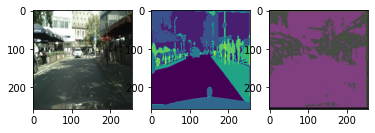

In [ ]:
x, y = next(val_dataset)

fig, axs = plt.subplots(nrows=1, ncols=3)

x = x[0]
y = y[0]

y = np.reshape(y, (256, 256))
axs[0].imshow(x.astype(np.int32))
axs[1].imshow(y)
fig.show()

x = np.expand_dims(x, 0)
y_hat = model(x)
y_hat = y_hat[0]

y_hat = np.argmax(y_hat, 2)
y_hat = np.reshape(y_hat, (-1,))
y_hat = km.cluster_centers_[y_hat]
y_hat = np.reshape(y_hat, (256, 256, 3))
y_hat = np.round_(y_hat).astype(np.int32)

axs[2].imshow(y_hat)
